In [1]:
import torch
import torchvision
from torch import nn
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import pyro
from src.semi_sub_utils import expCollector
from src.plot import plot_curve_solutions_regression, plot_predictive_regression
from src.semi_subspace import initialize_subspace_model_v2
from utils_datamodel.utils import FastFillTensorDataLoader
from torch.utils.data import random_split
from baselines.src.datasets import DatasetFactory
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError, MeanMetric
from src.base_models import NllLoss
import matplotlib.pyplot as plt
from src.model import getModel, RegNet
from src.semi_sub_utils import span_space_from_curve_model
from src.plot import plot_subspace
from tqdm import tqdm
from src.semi_sub_utils import log_pointwise_predictive_likelihood
from src.model import pyroSubspaceUCI, pyroSubspaceUCI_Zt
from src.plot import plot_subspace_solution_regression_pyro
from pyro.infer.autoguide import init_to_sample
import arviz as az
from pyro.poutine.indep_messenger import IndepMessenger
import seaborn as sns
from src.semi_subspace import load_subspace_model
from copy import deepcopy
import pandas as pd
import numpy as np
import arviz as az
from baselines.src.datasets import DATASETS_BENCHMARK, DATASETS_TOY
import json

%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./UCI_subspace.ipynb
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)



Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./UCI_subspace.ipynb
Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Recompute lppd

In [124]:
outcome_dist = pyro.distributions.Normal  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'loc': torch.nn.Identity()},
                  reduction='mean')
loss_fn.sigma = torch.nn.Parameter(torch.ones(1)*0.1) # register parameter
loss_fn.dist_.dist_kwargs = {'scale': loss_fn.sigma} # use sigma parameter in distribution
net_kwargs = dict(lr=1e-3,
                  weight_decay=0.,
                  loss_fn=loss_fn,
                  num_structure=0,
                  activation='tanh',
                  ortho_layer_name_nn_head=None
                  )

results = []
for r in wandb.Api().runs("ddold/uci_reg_benchmark"):
    if r.group == "SemiSub":
        # Load samples and model state dict
        print(r.name)
        for art in r.logged_artifacts():
            if "data" in art.name:
                samples_reload = az.from_netcdf(art.file())
            if "model_state" in art.name:
                state_dict = torch.load(art.file())
        # transform samples into pyro format
        samples_reload_pyro = {}
        for name in samples_reload.posterior.data_vars:
            var_samples = samples_reload.posterior[name].to_numpy()
            shape = (np.prod(var_samples.shape[:2]), *var_samples.shape[2:])
            var_samples = var_samples.reshape(shape)
            samples_reload_pyro[name] = torch.from_numpy(var_samples).to(device=device)
        # Load dataset
        print(r.config['dataset'])
        ds_name = r.config['dataset']
        if ds_name in DATASETS_BENCHMARK:
            split_file = 'baselines/data/dataset_indices_0.2.json'
        else:
            split_file = 'baselines/data/toy_dataset_indices_0.2.json'
        data_train, data_test = DatasetFactory.get(ds_name, splits=split_file, dataset_pth='baselines/data/', device=device)
        # instatiate pyro modle
        pyro.clear_param_store()
        if len(state_dict)>6:
            base_net_kwargs = {"dimensions": [16, 16, 16],
                            "output_dim": 1,
                            "input_dim": data_train.n_features}
        else:
            base_net_kwargs = {"dimensions": [3],
                            "output_dim": 1,
                            "input_dim": data_train.n_features}
        base_model = getModel(RegNet, seed=0, **base_net_kwargs, **net_kwargs).to(device=device)
        pyro_model = pyroSubspaceUCI(
            mean=state_dict['mean_unconstrained'],
            cov_factor=state_dict['cov_unconstrained'],
            sequential_dnn=base_model.dnn,
            outcome_dist=loss_fn.dist_)
        pyro_model.load_state_dict(torch.load(art.file()))
        # rerun lppd
        u_test, y_test = data_test[:]
        ll_pointwise = log_pointwise_predictive_likelihood(pyro_model, samples_reload_pyro, u=u_test, y=y_test.squeeze())
        lppd_test = torch.exp(ll_pointwise).mean(0).log().mean().item()
        stderr = torch.exp(ll_pointwise).mean(0).log().std().item() / np.sqrt(y_test.shape[0])
        assert np.isclose(r.summary['test_mlppd'], lppd_test), f"mlppd expected to be the same but was different. Computed: {lppd_test}, Loaded {r.summary['test_mlppd']}"
        r.summary['test_lppd_stderr'] = stderr

        # recompute unscaled lppd
        with open('mu_sigma.json', 'r') as f:
            mu_Simga = json.load(f)
        mu = mu_Simga[ds_name]['mean_y'][0]
        sigma = np.sqrt(mu_Simga[ds_name]['var_y']).item()
        y_test_scale = y_test*sigma + mu

        num_samples = list(samples_reload_pyro.values())[0].shape[0]
        log_probs = []
        samples = [
            {k: v[i] for k, v in samples_reload_pyro.items()} for i in range(num_samples)
        ]
        pyro_model_z = pyroSubspaceUCI_Zt(mean=pyro_model.mean,
                                            cov_factor=pyro_model.cov,
                                            sequential_dnn=getModel(RegNet, **base_net_kwargs, **net_kwargs).to(device=pyro_model.device).dnn,
                                            z_mean=mu,
                                            z_scale=sigma)
        ll_pointwise = log_pointwise_predictive_likelihood(pyro_model_z, samples_reload_pyro, u=u_test, y=y_test_scale.squeeze())
        lppd_test_u = torch.exp(ll_pointwise).mean(0).log().mean().item()
        stderr_u = torch.exp(ll_pointwise).mean(0).log().std().item() / np.sqrt(y_test_scale.shape[0])
        r.summary['test_mlppd_unscaled'] = lppd_test_u
        r.summary['test_lppd_u_stderr'] = stderr_u
        r.summary.update()

HMC_subspace_from_sqm4q2hh
yacht


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_aps53oz2


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


yacht
RegNet
RegNet
HMC_subspace_from_uu58evse
yacht


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_cknn203w
yacht


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_o83zhvsw


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


forest_fire
RegNet
RegNet
HMC_subspace_from_5sqy3o6h
forest_fire
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
HMC_subspace_from_qgpvy4im
forest_fire


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_408pduj5
forest_fire


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_u23mp6gz
energy


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_cryi67us


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


energy
RegNet
RegNet
HMC_subspace_from_p08xk0hd


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


energy
RegNet
RegNet
HMC_subspace_from_14utxurc


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


energy
RegNet
RegNet
HMC_subspace_from_hbk8098t
diabetes


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_tykxojh7
diabetes


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_4gtr48q1


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


diabetes
RegNet
RegNet
HMC_subspace_from_wgefeyov


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


diabetes
RegNet
RegNet
HMC_subspace_from_fjuau9s0
concrete


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_bx1c9od0


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


concrete
RegNet
RegNet
HMC_subspace_from_fgha0hlh
concrete


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_u2z1vtc3


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


concrete
RegNet
RegNet
HMC_subspace_from_99avhzbk
airfoil


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_3gqfbe00
airfoil


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_kornsl41
airfoil


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet
HMC_subspace_from_lsp5r1ti
airfoil


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_2ygtwwhn
sinusoidal
RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_69yf6dy5
sinusoidal
RegNet
RegNet
HMC_subspace_from_o1sqypzb


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


sinusoidal
RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_c13sfygg
sinusoidal
RegNet
RegNet
HMC_subspace_from_zkv2lvqn
regression2d
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_ql4xqoi4
regression2d
RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_b20o65o8
regression2d
RegNet
RegNet
HMC_subspace_from_f4jy52ho


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


regression2d
RegNet
RegNet
HMC_subspace_from_24p90z85


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


izmailov
RegNet
RegNet
HMC_subspace_from_lly6t0jl


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


izmailov
RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_zijwyvma
izmailov
RegNet
RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0


HMC_subspace_from_m5e0id1j
izmailov
RegNet
RegNet


In [125]:
(torch.logsumexp(ll_pointwise, dim=0) - np.log(ll_pointwise.shape[0])).mean()

tensor(0.4914, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
import torch
xx = torch.randn(10000000)*11 +3.3
mu = 3.
std = 2.

z_xx = (xx - mu)/std

print(z_xx.mean(), z_xx.std())

mu_x = z_xx.mean()*std + mu
print("mu_x", mu_x)

std_x = torch.sqrt(z_xx.var() * std**2)
print("std_x", std_x)

tensor(0.1477) tensor(5.5003)
mu_x tensor(3.2953)
std_x tensor(11.0006)


## analyse results

In [11]:
import pandas as pd
results = []
for r in wandb.Api().runs("ddold/uci_reg_benchmark"):
    if r.group == "SemiSub":
        print(r.name)
        results.append({'lppd': r.summary['test_mlppd'], 
                        'lppd_stderr': r.summary['test_lppd_stderr'], 
                        'u_lppd': r.summary['test_mlppd_unscaled'], 
                        'u_lppd_stderr': r.summary['test_lppd_u_stderr'], 
                        'subspace_dim':r.config['subspace_dimension'], 
                        'dataset':r.config['dataset'], 
                        'large_DNN':r.config['dnn_large'], 
                        'seed':r.config['seed']})
    
df = pd.DataFrame(results)
df = df.set_index('dataset').rename(index={'yacht': 'Yacht', 'forest_fire':'ForestF', 'energy': 'Energy', 'diabetes':'Diabetes', 'concrete':'Concrete', 'airfoil':'Airfoil', 'sinusoidal':'DS', 'regression2d': 'DR', 'izmailov': 'DI'})
df

HMC_subspace_from_sqm4q2hh
HMC_subspace_from_aps53oz2
HMC_subspace_from_uu58evse
HMC_subspace_from_cknn203w
HMC_subspace_from_o83zhvsw
HMC_subspace_from_5sqy3o6h
HMC_subspace_from_qgpvy4im
HMC_subspace_from_408pduj5
HMC_subspace_from_u23mp6gz
HMC_subspace_from_cryi67us
HMC_subspace_from_p08xk0hd
HMC_subspace_from_14utxurc
HMC_subspace_from_hbk8098t
HMC_subspace_from_tykxojh7
HMC_subspace_from_4gtr48q1
HMC_subspace_from_wgefeyov
HMC_subspace_from_fjuau9s0
HMC_subspace_from_bx1c9od0
HMC_subspace_from_fgha0hlh
HMC_subspace_from_u2z1vtc3
HMC_subspace_from_99avhzbk
HMC_subspace_from_3gqfbe00
HMC_subspace_from_kornsl41
HMC_subspace_from_lsp5r1ti
HMC_subspace_from_2ygtwwhn
HMC_subspace_from_69yf6dy5
HMC_subspace_from_o1sqypzb
HMC_subspace_from_c13sfygg
HMC_subspace_from_zkv2lvqn
HMC_subspace_from_ql4xqoi4
HMC_subspace_from_b20o65o8
HMC_subspace_from_f4jy52ho
HMC_subspace_from_24p90z85
HMC_subspace_from_lly6t0jl
HMC_subspace_from_zijwyvma
HMC_subspace_from_m5e0id1j


,lppd,lppd_stderr,u_lppd,u_lppd_stderr,subspace_dim,large_DNN,seed
dataset,,,,,,,
Yacht,1.487742,0.505540,-1.223710,0.505540,5,True,898
Yacht,-0.689829,1.897583,-3.401290,1.897595,2,True,898
Yacht,1.202254,0.444110,-1.509198,0.444109,5,False,59
Yacht,1.134120,0.474578,-1.577332,0.474578,2,False,59
ForestF,-1.378371,0.073102,-1.723021,0.073102,5,True,120
ForestF,-1.898202,0.188183,-2.242851,0.188183,2,True,120
ForestF,-1.368178,0.068962,-1.712827,0.068962,5,False,40
ForestF,-1.474377,0.080223,-1.819027,0.080223,2,False,40
Energy,1.568222,0.150570,-0.745213,0.150570,5,True,320


| dataset  | MCMC (chain)   | MCMC (s.c.)    | LA              | MCMC (ours)    | MCMC (s.c.)    | LA             |
|----------|----------------|----------------|-----------------|----------------|----------------|----------------|
| DS       | -0.53 (± 0.09) | -0.56 (± 0.11) | -0.57 (± 0.10)  | -0.59 (± 0.12) | -0.59 (± 0.12) | -2.42 (± 0.01) |
| DI       | 0.79 (± 0.06)  | 0.65 (± 0.07)  | 0.53 (± 0.07)   | 0.91 (± 0.09)  | 0.91 (± 0.09)  | -1.81 (± 0.01) |
| DR       | 0.64 (± 0.10)  | 0.75 (± 0.11)  | -27.39 (± 3.65) | 0.95 (± 0.08)  | 0.95 (± 0.08)  | -2.33 (± 0.00) |
| Airfoil  | -0.74 (± 0.04) | -0.80 (± 0.05) | -1.78 (± 0.13)  | 0.92 (± 0.05)  | 0.72 (± 0.10)  | -3.57 (± 0.18) |
| Concrete | -0.41 (± 0.05) | -0.44 (± 0.06) | -14.49 (± 1.02) | 0.26 (± 0.07)  | 0.25 (± 0.07)  | -4.36 (± 0.47) |
| Diabetes | -1.20 (± 0.07) | -1.20 (± 0.07) | -1.46 (± 0.09)  | -1.18 (± 0.08) | -1.22 (± 0.09) | -2.61 (± 0.00) |
| Energy   | 0.92 (± 0.04)  | 0.69 (± 0.12)  | -31.74 (± 1.88) | 2.07 (± 0.46)  | 2.38 (± 0.11)  | -1.39 (± 0.06) |
| ForestF  | -1.37 (± 0.07) | -1.37 (± 0.07) | -2.39 (± 0.16)  | -1.43 (± 0.45) | -1.69 (± 0.49) | -2.80 (± 0.00) |
| Yacht    | 1.90 (± 0.16)  | 1.29 (± 0.56)  | -5.60 (± 1.51)  | 3.31 (± 0.21)  | 0.15 (± 0.09)  | -2.69 (± 0.00) |

|          | Smaller network f1 |                |                |                 | Larger network f2 |                |                |                |
|----------|--------------------|----------------|----------------|-----------------|-------------------|----------------|----------------|----------------|
| dataset  | MCMC (chain)       | MCMC (s.c.)    | DE             | LA              | MCMC (ours)       | MCMC (s.c.)    | DE             | LA             |
| DS       | -0.53 (± 0.09)     | -0.56 (± 0.11) | -0.58 (± 0.11) | -0.57 (± 0.10)  | -0.59 (± 0.12)    | -0.59 (± 0.12) | -2.13 (± 0.03) | -2.42 (± 0.01) |
| DI       | 0.79 (± 0.06)      | 0.65 (± 0.07)  | 0.56 (± 0.06)  | 0.53 (± 0.07)   | 0.91 (± 0.09)     | 0.91 (± 0.09)  | -2.02 (± 0.02) | -1.81 (± 0.01) |
| DR       | 0.64 (± 0.10)      | 0.75 (± 0.11)  | -1.46 (± 0.06) | -27.39 (± 3.65) | 0.95 (± 0.08)     | 0.95 (± 0.08)  | -2.20 (± 0.02) | -2.33 (± 0.00) |
| Airfoil  | -0.74 (± 0.04)     | -0.80 (± 0.05) | -1.62 (± 0.03) | -1.78 (± 0.13)  | 0.92 (± 0.05)     | 0.72 (± 0.10)  | -2.17 (± 0.01) | -3.57 (± 0.18) |
| Concrete | -0.41 (± 0.05)     | -0.44 (± 0.06) | -1.59 (± 0.03) | -14.49 (± 1.02) | 0.26 (± 0.07)     | 0.25 (± 0.07)  | -2.03 (± 0.01) | -4.36 (± 0.47) |
| Diabetes | -1.20 (± 0.07)     | -1.20 (± 0.07) | -1.47 (± 0.07) | -1.46 (± 0.09)  | -1.18 (± 0.08)    | -1.22 (± 0.09) | -2.09 (± 0.04) | -2.61 (± 0.00) |
| Energy   | 0.92 (± 0.04)      | 0.69 (± 0.12)  | -1.76 (± 0.02) | -31.74 (± 1.88) | 2.07 (± 0.46)     | 2.38 (± 0.11)  | -1.99 (± 0.02) | -1.39 (± 0.06) |
| ForestF  | -1.37 (± 0.07)     | -1.37 (± 0.07) | -1.60 (± 0.06) | -2.39 (± 0.16)  | -1.43 (± 0.45)    | -1.69 (± 0.49) | -2.20 (± 0.02) | -2.80 (± 0.00) |
| Yacht    | 1.90 (± 0.16)      | 1.29 (± 0.56)  | -1.14 (± 0.14) | -5.60 (± 1.51)  | 3.31 (± 0.21)     | 0.15 (± 0.09)  | -2.18 (± 0.03) | -2.69 (± 0.00) |

In [10]:
import pandas as pd
from io import StringIO

# Your modified CSV data as a string
csv_data = """|Small network f1|Small network f1|Small network f1|Small network f1|Large network f2|Large network f2|Large network f2|Large network f2
dataset|MCMC(chain)|MCMC(s.c.)|DE|LA|MCMC(chain)|MCMC(s.c.)|DE|LA
DS|-0.53 (±0.09)|-0.56 (±0.11)|-0.58 (±0.11)|-0.57 (±0.10)|-0.59 (±0.12)|-0.59 (±0.12)|-2.13 (±0.03)|-2.42 (±0.01)
DI|0.79 (±0.06)|0.65 (±0.07)|0.56 (±0.06)|0.53 (±0.07)|0.91 (±0.09)|0.91 (±0.09)|-2.02 (±0.02)|-1.81 (±0.01)
DR|0.64 (±0.10)|0.75 (±0.11)|-1.46 (±0.06)|-27.39 (±3.65)|0.95 (±0.08)|0.95 (±0.08)|-2.20 (±0.02)|-2.33 (±0.00)
Airfoil|-0.74 (±0.04)|-0.80 (±0.05)|-1.62 (±0.03)|-1.78 (±0.13)|0.92 (±0.05)|0.72 (±0.10)|-2.17 (±0.01)|-3.57 (±0.18)
Concrete|-0.41 (±0.05)|-0.44 (±0.06)|-1.59 (±0.03)|-14.49 (±1.02)|0.26 (±0.07)|0.25 (±0.07)|-2.03 (±0.01)|-4.36 (±0.47)
Diabetes|-1.20 (±0.07)|-1.20 (±0.07)|-1.47 (±0.07)|-1.46 (±0.09)|-1.18 (±0.08)|-1.22 (±0.09)|-2.09 (±0.04)|-2.61 (±0.00)
Energy|0.92 (±0.04)|0.69 (±0.12)|-1.76 (±0.02)|-31.74 (±1.88)|2.07 (±0.46)|2.38 (±0.11)|-1.99 (±0.02)|-1.39 (±0.06)
ForestF|-1.37 (±0.07)|-1.37 (±0.07)|-1.60 (±0.06)|-2.39 (±0.16)|-1.43 (±0.45)|-1.69 (±0.49)|-2.20 (±0.02)|-2.80 (±0.00)
Yacht|1.90 (±0.16)|1.29 (±0.56)|-1.14 (±0.14)|-5.60 (±1.51)|3.31 (±0.21)|0.15 (±0.09)|-2.18 (±0.03)|-2.69 (±0.00)
"""

# Load the CSV data into a DataFrame
df_load = pd.read_csv(StringIO(csv_data), header=[0, 1], index_col=0, sep='|')
df_load


Small network f1                                                 
dataset       MCMC(chain)     MCMC(s.c.)             DE              LA   
DS          -0.53 (±0.09)  -0.56 (±0.11)  -0.58 (±0.11)   -0.57 (±0.10)  \
DI           0.79 (±0.06)   0.65 (±0.07)   0.56 (±0.06)    0.53 (±0.07)   
DR           0.64 (±0.10)   0.75 (±0.11)  -1.46 (±0.06)  -27.39 (±3.65)   
Airfoil     -0.74 (±0.04)  -0.80 (±0.05)  -1.62 (±0.03)   -1.78 (±0.13)   
Concrete    -0.41 (±0.05)  -0.44 (±0.06)  -1.59 (±0.03)  -14.49 (±1.02)   
Diabetes    -1.20 (±0.07)  -1.20 (±0.07)  -1.47 (±0.07)   -1.46 (±0.09)   
Energy       0.92 (±0.04)   0.69 (±0.12)  -1.76 (±0.02)  -31.74 (±1.88)   
ForestF     -1.37 (±0.07)  -1.37 (±0.07)  -1.60 (±0.06)   -2.39 (±0.16)   
Yacht        1.90 (±0.16)   1.29 (±0.56)  -1.14 (±0.14)   -5.60 (±1.51)   

         Large network f2                                               
dataset       MCMC(chain)     MCMC(s.c.)             DE             LA  
DS          -0.59 (±0.12)  -0.59 (±0.12)  -2.13 (±0.03)  -2.42 (±0.01)  
DI           0.91 (±0.09)   0.91 (±0.09)  -2.02 (±0.02)  -1.81 (±0.01)  
DR           0.95 (±0.08)   0.95 (±0.08)  -2.20 (±0.02)  -2.33 (±0.00)  
Airfoil      0.92 (±0.05)   0.72 (±0.10)  -2.17 (±0.01)  -3.57 (±0.18)  
Concrete     0.26 (±0.07)   0.25 (±0.07)  -2.03 (±0.01)  -4.36 (±0.47)  
Diabetes    -1.18 (±0.08)  -1.22 (±0.09)  -2.09 (±0.04)  -2.61 (±0.00)  
Energy       2.07 (±0.46)   2.38 (±0.11)  -1.99 (±0.02)  -1.39 (±0.06)  
ForestF     -1.43 (±0.45)  -1.69 (±0.49)  -2.20 (±0.02)  -2.80 (±0.00)  
Yacht        3.31 (±0.21)   0.15 (±0.09)  -2.18 (±0.03)  -2.69 (±0.00)

In [11]:
df_sub1 = df[(df['large_DNN'] == False) & (df['subspace_dim'] == 2)]
df_sub1.insert(0,'lppd_des',df_sub1.apply(lambda row: f"{row.lppd:.2f} (± {row.lppd_stderr:.2f})", axis=1))
df_load.insert(loc=2, column=('Small network f1', 'Subspace (dim=2)'), value=df_sub1['lppd_des'])
df_sub1 = df[(df['large_DNN'] == False) & (df['subspace_dim'] == 5)]
df_sub1.insert(0,'lppd_des',df_sub1.apply(lambda row: f"{row.lppd:.2f} (± {row.lppd_stderr:.2f})", axis=1))
df_load.insert(loc=3, column=('Small network f1', 'Subspace (dim=5)'), value=df_sub1['lppd_des'])
df_sub1 = df[(df['large_DNN'] == True) & (df['subspace_dim'] == 2)]
df_sub1.insert(0,'lppd_des',df_sub1.apply(lambda row: f"{row.lppd:.2f} (± {row.lppd_stderr:.2f})", axis=1))
df_load.insert(loc=8, column=('Large network f2', 'Subspace (dim=2)'), value=df_sub1['lppd_des'])
df_sub1 = df[(df['large_DNN'] == True) & (df['subspace_dim'] == 5)]
df_sub1.insert(0,'lppd_des',df_sub1.apply(lambda row: f"{row.lppd:.2f} (± {row.lppd_stderr:.2f})", axis=1))
df_load.insert(loc=9, column=('Large network f2', 'Subspace (dim=5)'), value=df_sub1['lppd_des'])
df_load

Small network f1                                                    
dataset       MCMC(chain)     MCMC(s.c.) Subspace (dim=2) Subspace (dim=5)   
DS          -0.53 (±0.09)  -0.56 (±0.11)   -0.58 (± 0.11)   -0.60 (± 0.11)  \
DI           0.79 (±0.06)   0.65 (±0.07)    0.51 (± 0.06)    0.60 (± 0.05)   
DR           0.64 (±0.10)   0.75 (±0.11)   -0.39 (± 0.11)    0.57 (± 0.12)   
Airfoil     -0.74 (±0.04)  -0.80 (±0.05)   -0.88 (± 0.05)   -0.83 (± 0.06)   
Concrete    -0.41 (±0.05)  -0.44 (±0.06)   -0.53 (± 0.06)   -0.50 (± 0.06)   
Diabetes    -1.20 (±0.07)  -1.20 (±0.07)   -1.24 (± 0.09)   -1.17 (± 0.06)   
Energy       0.92 (±0.04)   0.69 (±0.12)   -0.05 (± 0.07)    0.62 (± 0.08)   
ForestF     -1.37 (±0.07)  -1.37 (±0.07)   -1.47 (± 0.08)   -1.37 (± 0.07)   
Yacht        1.90 (±0.16)   1.29 (±0.56)    1.13 (± 0.47)    1.20 (± 0.44)   

                                        Large network f2                  
dataset              DE              LA      MCMC(chain)     MCMC(s.c.)   
DS        -0.58 (±0.11)   -0.57 (±0.10)    -0.59 (±0.12)  -0.59 (±0.12)  \
DI         0.56 (±0.06)    0.53 (±0.07)     0.91 (±0.09)   0.91 (±0.09)   
DR        -1.46 (±0.06)  -27.39 (±3.65)     0.95 (±0.08)   0.95 (±0.08)   
Airfoil   -1.62 (±0.03)   -1.78 (±0.13)     0.92 (±0.05)   0.72 (±0.10)   
Concrete  -1.59 (±0.03)  -14.49 (±1.02)     0.26 (±0.07)   0.25 (±0.07)   
Diabetes  -1.47 (±0.07)   -1.46 (±0.09)    -1.18 (±0.08)  -1.22 (±0.09)   
Energy    -1.76 (±0.02)  -31.74 (±1.88)     2.07 (±0.46)   2.38 (±0.11)   
ForestF   -1.60 (±0.06)   -2.39 (±0.16)    -1.43 (±0.45)  -1.69 (±0.49)   
Yacht     -1.14 (±0.14)   -5.60 (±1.51)     3.31 (±0.21)   0.15 (±0.09)   

                                                                          
dataset  Subspace (dim=2) Subspace (dim=5)             DE             LA  
DS         -0.68 (± 0.14)   -0.70 (± 0.15)  -2.13 (±0.03)  -2.42 (±0.01)  
DI          0.82 (± 0.10)    0.77 (± 0.09)  -2.02 (±0.02)  -1.81 (±0.01)  
DR          0.82 (± 0.13)    0.86 (± 0.12)  -2.20 (±0.02)  -2.33 (±0.00)  
Airfoil    -0.28 (± 0.12)   -0.19 (± 0.09)  -2.17 (±0.01)  -3.57 (±0.18)  
Concrete   -0.53 (± 0.20)   -0.55 (± 0.17)  -2.03 (±0.01)  -4.36 (±0.47)  
Diabetes   -2.40 (± 0.28)   -1.21 (± 0.08)  -2.09 (±0.04)  -2.61 (±0.00)  
Energy      1.43 (± 0.14)    1.57 (± 0.15)  -1.99 (±0.02)  -1.39 (±0.06)  
ForestF    -1.90 (± 0.19)   -1.38 (± 0.07)  -2.20 (±0.02)  -2.80 (±0.00)  
Yacht      -0.69 (± 1.90)    1.49 (± 0.51)  -2.18 (±0.03)  -2.69 (±0.00)

In [62]:
df_load.to_csv('benchmark_results.csv')

In [12]:
print(df_load['Small network f1'].to_latex())

\begin{tabular}{lllllll}
\toprule
dataset & MCMC(chain) & MCMC(s.c.) & Subspace (dim=2) & Subspace (dim=5) & DE & LA \\
\midrule
DS & -0.53 (±0.09) & -0.56 (±0.11) & -0.58 (± 0.11) & -0.60 (± 0.11) & -0.58 (±0.11) & -0.57 (±0.10) \\
DI & 0.79 (±0.06) & 0.65 (±0.07) & 0.51 (± 0.06) & 0.60 (± 0.05) & 0.56 (±0.06) & 0.53 (±0.07) \\
DR & 0.64 (±0.10) & 0.75 (±0.11) & -0.39 (± 0.11) & 0.57 (± 0.12) & -1.46 (±0.06) & -27.39 (±3.65) \\
Airfoil & -0.74 (±0.04) & -0.80 (±0.05) & -0.88 (± 0.05) & -0.83 (± 0.06) & -1.62 (±0.03) & -1.78 (±0.13) \\
Concrete & -0.41 (±0.05) & -0.44 (±0.06) & -0.53 (± 0.06) & -0.50 (± 0.06) & -1.59 (±0.03) & -14.49 (±1.02) \\
Diabetes & -1.20 (±0.07) & -1.20 (±0.07) & -1.24 (± 0.09) & -1.17 (± 0.06) & -1.47 (±0.07) & -1.46 (±0.09) \\
Energy & 0.92 (±0.04) & 0.69 (±0.12) & -0.05 (± 0.07) & 0.62 (± 0.08) & -1.76 (±0.02) & -31.74 (±1.88) \\
ForestF & -1.37 (±0.07) & -1.37 (±0.07) & -1.47 (± 0.08) & -1.37 (± 0.07) & -1.60 (±0.06) & -2.39 (±0.16) \\
Yacht & 1.90 (±0.16) &

In [13]:
print(df_load['Large network f2'].to_latex())

\begin{tabular}{lllllll}
\toprule
dataset & MCMC(chain) & MCMC(s.c.) & Subspace (dim=2) & Subspace (dim=5) & DE & LA \\
\midrule
DS & -0.59 (±0.12) & -0.59 (±0.12) & -0.68 (± 0.14) & -0.70 (± 0.15) & -2.13 (±0.03) & -2.42 (±0.01) \\
DI & 0.91 (±0.09) & 0.91 (±0.09) & 0.82 (± 0.10) & 0.77 (± 0.09) & -2.02 (±0.02) & -1.81 (±0.01) \\
DR & 0.95 (±0.08) & 0.95 (±0.08) & 0.82 (± 0.13) & 0.86 (± 0.12) & -2.20 (±0.02) & -2.33 (±0.00) \\
Airfoil & 0.92 (±0.05) & 0.72 (±0.10) & -0.28 (± 0.12) & -0.19 (± 0.09) & -2.17 (±0.01) & -3.57 (±0.18) \\
Concrete & 0.26 (±0.07) & 0.25 (±0.07) & -0.53 (± 0.20) & -0.55 (± 0.17) & -2.03 (±0.01) & -4.36 (±0.47) \\
Diabetes & -1.18 (±0.08) & -1.22 (±0.09) & -2.40 (± 0.28) & -1.21 (± 0.08) & -2.09 (±0.04) & -2.61 (±0.00) \\
Energy & 2.07 (±0.46) & 2.38 (±0.11) & 1.43 (± 0.14) & 1.57 (± 0.15) & -1.99 (±0.02) & -1.39 (±0.06) \\
ForestF & -1.43 (±0.45) & -1.69 (±0.49) & -1.90 (± 0.19) & -1.38 (± 0.07) & -2.20 (±0.02) & -2.80 (±0.00) \\
Yacht & 3.31 (±0.21) & 0.15 (

In [5]:
print(df_load.to_latex())

\begin{tabular}{lllllllllllll}
\toprule
 & \multicolumn{6}{r}{Small network f1} & \multicolumn{5}{r}{Large network f2} & Large network f2               \\
dataset & MCMC(chain) & MCMC(s.c.) & Subspace (dim=2) & Subspace (dim=5) & DE & LA & MCMC(chain) & MCMC(s.c.) & Subspace (dim=2) & Subspace (dim=5) & DE & LA \\
\midrule
DS & -0.53 (±0.09) & -0.56 (±0.11) & -0.58 (± 0.11) & -0.60 (± 0.11) & -0.58 (±0.11) & -0.57 (±0.10) & -0.59 (±0.12) & -0.59 (±0.12) & -0.68 (± 0.14) & -0.70 (± 0.15) & -2.13 (±0.03) & -2.42 (±0.01) \\
DI & 0.79 (±0.06) & 0.65 (±0.07) & 0.51 (± 0.06) & 0.60 (± 0.05) & 0.56 (±0.06) & 0.53 (±0.07) & 0.91 (±0.09) & 0.91 (±0.09) & 0.82 (± 0.10) & 0.77 (± 0.09) & -2.02 (±0.02) & -1.81 (±0.01) \\
DR & 0.64 (±0.10) & 0.75 (±0.11) & -0.39 (± 0.11) & 0.57 (± 0.12) & -1.46 (±0.06) & -27.39 (±3.65) & 0.95 (±0.08) & 0.95 (±0.08) & 0.82 (± 0.13) & 0.86 (± 0.12) & -2.20 (±0.02) & -2.33 (±0.00) \\
Airfoil & -0.74 (±0.04) & -0.80 (±0.05) & -0.88 (± 0.05) & -0.83 (± 0.06) & -1.62 (±0

### compare with active subspace

In [47]:
import pandas as pd
from io import StringIO

# Sample data as a string (replace this with your actual data)
import pandas as pd
from io import StringIO

# Sample data as a string (replace this with your actual data)
table_data = """dataset SGD VI SGD-PCA AS LIS
boston -2.75 -2.72 -2.73 -2.76 -2.72
concrete -3.17 -3.29 -3.09 -3.05 -3.04
energy -2.36 -2.18 -2.39 -2.41 -2.35
naval 5.44 5.21 5.55 5.58 5.56
yacht -0.96 -2.40 -0.59 -0.89 -0.94"""

# Use StringIO to create a file-like object
data_file = StringIO(table_data)

# Read the data using pd.read_csv()
active_nll = pd.read_csv(data_file, delim_whitespace=True, header=0).set_index('dataset')
active_nll


,SGD,VI,SGD-PCA,AS,LIS
dataset,,,,,
boston,-2.75,-2.72,-2.73,-2.76,-2.72
concrete,-3.17,-3.29,-3.09,-3.05,-3.04
energy,-2.36,-2.18,-2.39,-2.41,-2.35
naval,5.44,5.21,5.55,5.58,5.56
yacht,-0.96,-2.40,-0.59,-0.89,-0.94


In [51]:


unnorm_scale = (df['lppd'] - df['u_lppd']).groupby('dataset').mean()
scaled = active_nll.loc['concrete',:] + unnorm_scale['Concrete'].item()
scaled1 = active_nll.loc['energy',:] + unnorm_scale['Energy'].item()
scaled2 = active_nll.loc['yacht',:] + unnorm_scale['Yacht'].item()
active_normalized = pd.concat([scaled, scaled1, scaled2], axis=1).T
print(active_normalized.to_latex(float_format="{:.3f}".format))
(df['lppd'] - df['u_lppd'])

\begin{tabular}{lrrrrr}
\toprule
 & SGD & VI & SGD-PCA & AS & LIS \\
\midrule
concrete & -0.367 & -0.487 & -0.287 & -0.247 & -0.237 \\
energy & -0.047 & 0.133 & -0.077 & -0.097 & -0.037 \\
yacht & 1.751 & 0.311 & 2.121 & 1.821 & 1.771 \\
\bottomrule
\end{tabular}



dataset
Yacht       2.711452
Yacht       2.711460
Yacht       2.711452
Yacht       2.711452
ForestF     0.344650
ForestF     0.344649
ForestF     0.344650
ForestF     0.344649
Energy      2.313435
Energy      2.313435
Energy      2.313435
Energy      2.313435
Diabetes    4.345294
Diabetes    4.345294
Diabetes    4.345294
Diabetes    4.345293
Concrete    2.803011
Concrete    2.803011
Concrete    2.803011
Concrete    2.803011
Airfoil     1.939530
Airfoil     1.939530
Airfoil     1.939530
Airfoil     1.939530
DS         -0.013031
DS         -0.013031
DS         -0.013031
DS         -0.013031
DR         -0.015621
DR         -0.015621
DR         -0.015621
DR         -0.015621
DI          0.018631
DI          0.018631
DI          0.018631
DI          0.018631
dtype: float64

## Run single benchmark

In [ ]:
# load dataset
ds_name = 'airfoil'
ds_name = 'yacht'
data_train, data_test = DatasetFactory.get(ds_name, splits='baselines/data/dataset_indices_0.2.json', dataset_pth='baselines/data/', device=device)
ds_name = 'izmailov'
data_train, data_test = DatasetFactory.get(ds_name, splits='baselines/data/toy_dataset_indices_0.2.json', dataset_pth='baselines/data/', device=device)

# define hyper parameters
seed = 20
base_net_kwargs = {"dimensions": [3],
                   "output_dim": 1,
                   "input_dim": data_train.n_features}
# base_net_kwargs = {"dimensions": [16, 16, 16],
#                    "output_dim": 1,
#                    "input_dim": data_train.n_features}
outcome_dist = pyro.distributions.Normal  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'loc': torch.nn.Identity()},
                  reduction='mean')
loss_fn.sigma = torch.nn.Parameter(torch.ones(1)*0.1) # register parameter
loss_fn.dist_.dist_kwargs = {'scale': loss_fn.sigma} # use sigma parameter in distribution
net_kwargs = dict(lr=1e-3,
                  weight_decay=0.,
                  loss_fn=loss_fn,
                  num_structure=0,
                  activation='tanh',
                  ortho_layer_name_nn_head=None
                  )
# define metrics for val and test data
metric_col = MetricCollection(MeanAbsoluteError(), MeanSquaredError(squared=False))

# collect all parameters
exp_col = expCollector(wandb_project='uci_reg_subspace',
                       use_ortho=False,
                       seed=seed,
                       base_net_kwargs=base_net_kwargs,
                       net_kwargs=net_kwargs,
                       nll_fn=loss_fn,
                       max_epochs=1000,
                       num_bends=3,
                       metric_collection=metric_col)

# define train val and test dataloader
prop_val = 0.3
val_set_size = int(len(data_train) * prop_val)
train_set_size = len(data_train) - val_set_size
seed = torch.Generator().manual_seed(seed)
train_set, val_set = random_split(
    data_train, [train_set_size, val_set_size], generator=seed
)

exp_col.train_dataloader  = FastFillTensorDataLoader(train_set, batch_size=len(train_set)//5, shuffle=True,
                                       pin_memory=False)
exp_col.valid_dataloader  = FastFillTensorDataLoader(val_set, batch_size=len(val_set), shuffle=False,
                                       pin_memory=False)
exp_col.test_dataloader  = FastFillTensorDataLoader(data_test, batch_size=len(data_test), shuffle=False,
                                            pin_memory=False)


In [10]:


def plot_curve_solutions_uci_regression(exp_col: expCollector, best_curve_model, wandb_logger):
    plt.figure(figsize=(9., 7.))
    # %% plot performance along curve
    dataset_test = exp_col.test_dataloader.dataset
    x_train, y_train = dataset_test[:]
    device = x_train.device
    best_curve_model = best_curve_model.to(device=device)
    t_space = torch.linspace(0, 1., 101, device=device)
    nll_vs_t = []
    for t in t_space:
        out = best_curve_model.model(x_train, t)
        nll = exp_col.nll_fn(out, y_train.squeeze(-1)).mean()
        nll_vs_t.append(nll.detach().cpu().item())
    plt.plot(t_space.cpu().numpy(), nll_vs_t)
    plt.xlabel("Bézier curve t-space")
    plt.ylabel(r'nll ~ $N(y|\mu=DNN(),\sigma=0.005)$')
    wandb_logger.experiment.log({"Bézier Curve NLL": wandb.Image(plt.gcf())})

    # %% plot predictive performance
    # z = np.linspace(-10, 10, 100)
    # feature = (features(z) - exp_col.f_mean) / exp_col.f_std
    # inp = torch.from_numpy(feature.astype(np.float32)).to(device=device)
    # trajectories = []
    # for t in t_space:
    #     out = best_curve_model.model(inp, t)
    #     trajectories.append(out.detach().cpu().numpy().ravel())
    # trajectories = np.vstack(trajectories)

    # def plot_samples(x_axis, preds, ax, color='blue'):
    #     mu = preds.mean(0)
    #     sigma = preds.std(0)

    #     ax.plot(x_axis, mu, "-", lw=2., color=color)
    #     ax.plot(x_axis, mu - 3 * sigma, "-", lw=0.75, color=color)
    #     ax.plot(x_axis, mu + 3 * sigma, "-", lw=0.75, color=color)

    #     np.random.shuffle(preds)
    #     for traj in preds[:10]:
    #         ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    #     ax.fill_between(x_axis, mu - 3 * sigma, mu + 3 * sigma, alpha=0.35, color=color)

    # fig = plt.figure(figsize=(9., 7.))
    # plot_data(exp_col)
    # ax = fig.gca()
    # plot_samples(z, trajectories, ax=ax, color=sns.color_palette()[0])
    # plt.title("Curve Solution")
    # wandb_logger.experiment.log({"prediction": wandb.Image(plt.gcf())})

    # %% plot subspace
    mean, cov, S = span_space_from_curve_model(best_curve_model.model.cpu(), exp_col.num_bends)
    subspace_model = getModel(RegNet, mean=mean, cov_factor=cov, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(
        device=device)
    metric_collection_base = MetricCollection([MeanSquaredError(squared=False),
                                               MeanAbsoluteError(),
                                               ]).to(device=device)
    # do grid for the first two dimensions of the subspace
    x = np.linspace(-6, 6, 40, dtype=np.float32)
    y = np.linspace(-6, 6, 40, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    grid = np.vstack([xx.flatten(), yy.flatten()]).T
    all_metrics = []
    metric_collection = metric_collection_base.clone()
    with torch.no_grad():
        for p in tqdm(grid):
            metric_collection.reset()
            p_t = torch.from_numpy(p).to(device=device)
            p_t = torch.concat([p_t, torch.zeros(exp_col.num_bends - 3, device=device)])
            subspace_model.set_parameter_vector(p_t)
            nll = 0.
            for data, y in exp_col.train_dataloader:
                # y = y.cuda() if y.device is not device else y
                p_pred = subspace_model(data)
                # nll += subspace_model.loss_fn(p_pred, y).item()
                nll += exp_col.nll_fn(p_pred, y.squeeze(-1)).mean().item()
                metric_collection.update(exp_col.nll_fn.dist_(p_pred).mean, y.squeeze(-1))
            metrics = metric_collection.compute()
            metrics['nll'] = nll / len(exp_col.train_dataloader)
            all_metrics.append(metrics)
    df_grid = pd.DataFrame(all_metrics)
    df_grid['MeanSquaredError'] = df_grid['MeanSquaredError'].apply(lambda x: x.item())
    df_grid['MeanAbsoluteError'] = df_grid['MeanAbsoluteError'].apply(lambda x: x.item())
    df_grid['xx'] = xx.flatten()
    df_grid['yy'] = yy.flatten()
    all_curve_params = [np.array([])] * exp_col.num_bends
    for n, p in best_curve_model.named_parameters():
        control_point_i = n.split('.')[-1]
        if '_' in control_point_i:
            control_point_i = int(control_point_i.split('_')[1])
            all_curve_params[control_point_i] = np.hstack(
                [all_curve_params[control_point_i], p.detach().clone().flatten().numpy()])
    all_curve_params = torch.as_tensor(all_curve_params)
    p_inv = np.linalg.pinv(cov.cpu().numpy().T)
    cp = (all_curve_params.cpu().numpy() - mean.cpu().numpy()) @ p_inv.T  # control points in the subspace
    fig = plot_subspace(df_grid, "nll", cp[0, :2], cp[1:-1, :2], cp[-1, :2], linear_color=False, interpolate=True)
    wandb_logger.experiment.log({"train_grid_nll": wandb.Image(fig)})
    fig = plot_subspace(df_grid, "MeanSquaredError", cp[0, :2], cp[1:-1, :2], cp[-1, :2], linear_color=True,
                        interpolate=False)
    wandb_logger.experiment.log({"train_grid_MSE": wandb.Image(fig)})
    fig = plot_subspace(df_grid, "MeanAbsoluteError", cp[0, :2], cp[1:-1, :2], cp[-1, :2], linear_color=True,
                        interpolate=False)
    wandb_logger.experiment.log({"train_grid_MAE": wandb.Image(fig)})
    w_table = wandb.Table(dataframe=df_grid)
    wandb_logger.experiment.log({"train_grid": w_table})

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 20


RegNet


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 20
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medi

Sanity Checking: 0it [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3000` reached.
wandb: Adding directory to artifact (./wandb/run-20231002_004412-l5bcej5c/files/checkpoints)... Done. 0.0s
Global seed set to 20


Sigma:  Parameter containing:
tensor([0.1514], requires_grad=True)
Sigma:  Parameter containing:
tensor([0.1508], device='cuda:0', requires_grad=True)


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(


Subspace
RegNet


100%|██████████| 1600/1600 [00:06<00:00, 231.53it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/loss_epoch,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid/MeanAbsoluteError,█▅▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/MeanSquaredError,█▅▄▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,2999
train/loss_epoch,-0.45889
train/loss_step,-0.71937
trainer/global_step,17999


***************************
* Initialisation finished *
***************************


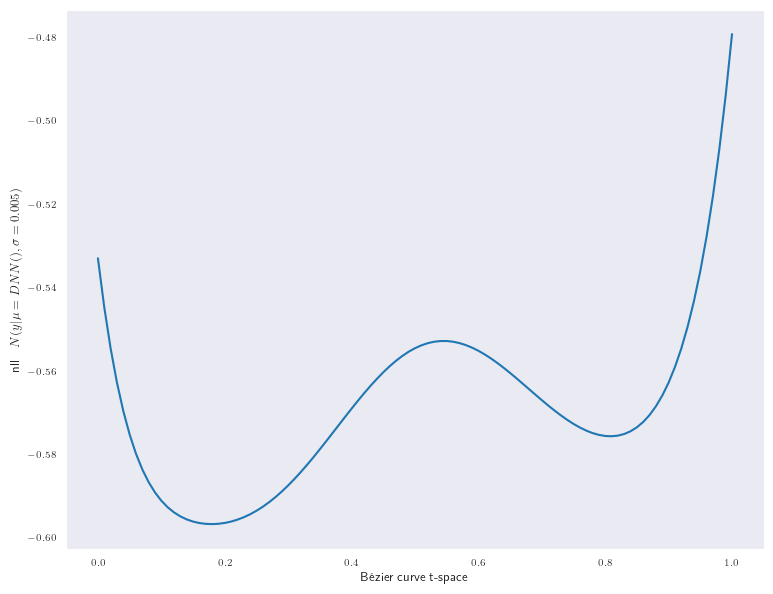

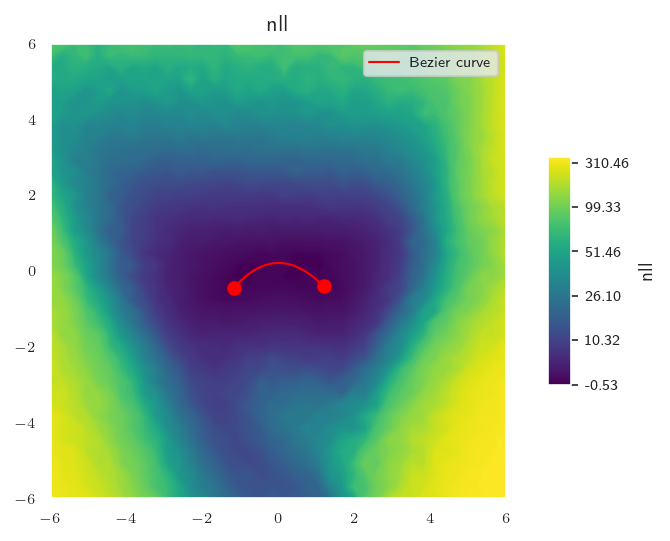

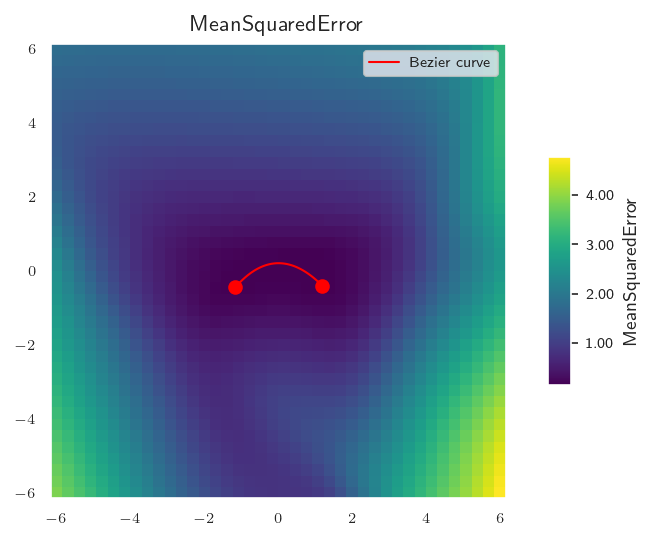

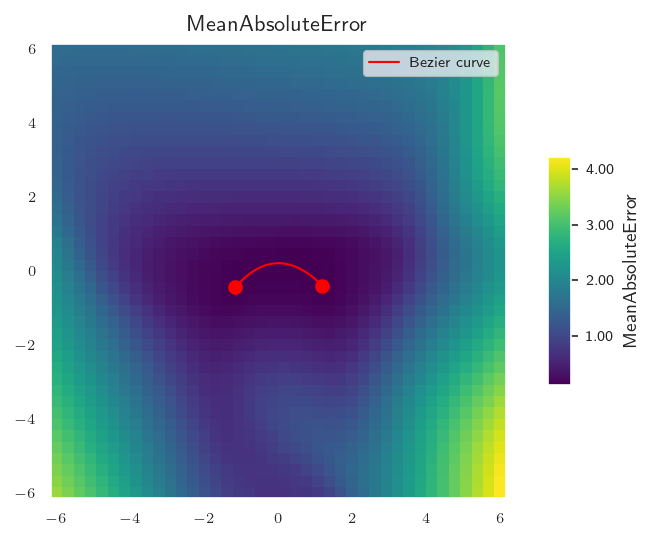

In [11]:
# define Projection matrix (Train curve model)
best_curve_model, wandb_curve_exp_id, _, wandb_logger = initialize_subspace_model_v2(
    exp_col=exp_col,
    plot_predictive_f=lambda *x, **xargs: None,
    plot_curve_solution_f=plot_curve_solutions_uci_regression)
wandb_logger.experiment.config['base_net_kwargs'] = base_net_kwargs
wandb_logger.experiment.config['net_kwargs'] = net_kwargs
wandb_logger.experiment.config['dataset'] = ds_name
wandb.finish()
print("*" * 27)
print("* Initialisation finished *")
print("*" * 27)

In [12]:
best_curve_model.loss_fn.sigma

Parameter containing:
tensor([0.1508], device='cuda:0', requires_grad=True)

In [13]:
trainer = pl.Trainer(devices=1)
trainer.test(best_curve_model, dataloaders=exp_col.test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorc

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/MeanAbsoluteError   │    0.10745837539434433    │
│   test/MeanSquaredError   │    0.13464896380901337    │
│         test/loss         │    -0.5742149949073792    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': -0.5742149949073792,
  'test/MeanAbsoluteError': 0.10745837539434433,
  'test/MeanSquaredError': 0.13464896380901337}]

In [45]:
trainer = pl.Trainer(devices=1)
trainer.test(best_curve_model, dataloaders=exp_col.test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/MeanAbsoluteError   │    0.7086748480796814     │
│   test/MeanSquaredError   │    1.0539309978485107     │
│         test/loss         │    1.4601490497589111     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 1.4601490497589111,
  'test/MeanAbsoluteError': 0.7086748480796814,
  'test/MeanSquaredError': 1.0539309978485107}]

# lppd
lppd = $\sum^n_{i=1} log (\frac{1}{S} \sum^S_{s=1}p(y_i|\theta_s))$

lppd = $\sum^n_{i=1} log (\frac{1}{S} \sum^S_{s=1} e^{log(p(y_i|\theta_s)}))$

lppd = $\sum^n_{i=1} log (\sum^S_{s=1} e^{log(p(y_i|\theta_s)}) - log(S))$



In [14]:

def run_hmc_on_subspace_no_struct(num_chains, num_warmup, num_samples, prior_scale, exp_col:expCollector, curve_model, curve_wandb_id):
    # create subspace model
    subspace_model, wandb_logger = load_subspace_model(exp_col,
                                                       curve_model,
                                                       curve_wandb_id)
    subspace_model_ = deepcopy(subspace_model)

    # %% Run HMC on the subspace
    torch.set_default_dtype(torch.float32)
    pyro.clear_param_store()

    pyro_model = pyroSubspaceUCI(
        mean=subspace_model_.mean.to(dtype=torch.float32),
        cov_factor=subspace_model_.cov_factor.to(dtype=torch.float32),
        sequential_dnn=subspace_model_.dnn,
        outcome_dist=exp_col.nll_fn.dist_)
    print(pyro_model.device)

    pyro.set_rng_seed(exp_col.seed+3)
    u_train = torch.vstack([exp_col.train_dataloader.dataset[:][0], exp_col.valid_dataloader.dataset[:][0]])
    y_train = torch.vstack([exp_col.train_dataloader.dataset[:][1], exp_col.valid_dataloader.dataset[:][1]])
    nuts_kernel = pyro.infer.NUTS(pyro_model,
                                    jit_compile=False,
                                    adapt_step_size=True,
                                    step_size=1e-5,
                                    target_accept_prob=0.8,
                                    init_strategy=init_to_sample)
    mcmc = pyro.infer.MCMC(nuts_kernel,
                        num_samples=num_samples,
                        warmup_steps=num_warmup,
                        num_chains=num_chains,
                        mp_context='spawn')
    mcmc.run(u_train, y_train.squeeze())
    wandb_logger.experiment.config.update({'num_chains': num_chains,
                                            'num_warmup': num_warmup,
                                            'num_samples': num_samples,
                                            'prior_scale': prior_scale,
                                            'seed': exp_col.seed,
                                            'Subspace_dimension': exp_col.num_bends - 1})
    # create arviz inference object
    az_post_hmc = az.from_pyro(mcmc, log_likelihood=False)
    # save samples with wandb
    az_post_hmc.to_netcdf("az_subspace_posterior.nc")
    art = wandb.Artifact(f"data_{wandb_logger.experiment.id}", type="xarray",
                            description="posterior from subspace model")
    art.add_file("az_subspace_posterior.nc")
    wandb_logger.experiment.log_artifact(art)
    # save pyro model state dict
    torch.save(pyro_model.state_dict(), "model_state_dict.pt")
    art = wandb.Artifact(f"model_state_{wandb_logger.experiment.id}", type="pyroSemiSubspace",
                            description="pyro model state dict")
    art.add_file("model_state_dict.pt")
    wandb_logger.experiment.log_artifact(art)

    # # compute valid lppd
    # if exp_col.valid_dataloader is not None:
    #     u_valid, y_valid = exp_col.valid_dataloader.dataset[:]
    #     lppd_valid = log_pointwise_predictive_likelihood(pyro_model, mcmc.get_samples(), u=u_valid, y=y_valid.squeeze())
    #     lppd_valid = (torch.logsumexp(lppd_valid, dim=0) - np.log(lppd_valid.shape[0])).sum()
    #     wandb_logger.experiment.summary["valid_mlppd"] = lppd_valid / len(y_valid)

    # compute test lppd
    if exp_col.test_dataloader is not None:
        u_test, y_test = exp_col.test_dataloader.dataset[:]
        lppd_test = log_pointwise_predictive_likelihood(pyro_model, mcmc.get_samples(), u=u_test, y=y_test.squeeze())
        lppd_test = (torch.logsumexp(lppd_test, dim=0) - np.log(lppd_test.shape[0])).sum()
        wandb_logger.experiment.summary["test_mlppd"] = lppd_test / len(y_test)

    # compute grid
    if exp_col.num_bends == 3:
        # compute grid
        device = pyro_model.device
        x = np.linspace(-10, 10, 40, dtype=np.float32)
        y = np.linspace(-8, 8, 40, dtype=np.float32)
        xx, yy = np.meshgrid(x, y)
        grid = np.vstack([xx.flatten(), yy.flatten()]).T
        with IndepMessenger("grid", size=grid.shape[0], dim=-2):
            cond_model = pyro.condition(pyro_model, data={"varphi": torch.from_numpy(grid).to(device=device)})
            trace = pyro.poutine.trace(cond_model).get_trace(u_test, y_test.squeeze(-1))
            trace.compute_log_prob()
        log_like = trace.nodes['obs']['log_prob'].sum(1).detach().cpu().numpy()
        log_prob_joint = log_like.copy()
        # log_prob_joint += trace.nodes['structure_nn.weight']['log_prob'].item()  # wasn't broadcasted => single value
        log_prob_joint += trace.nodes['varphi']['log_prob'].detach().cpu().numpy()
        log_prob_joint = np.nan_to_num(log_prob_joint, nan=np.nan_to_num(-np.inf))
        df = pd.DataFrame.from_dict(dict(xx=xx.flatten(),
                                            yy=yy.flatten(),
                                            log_like=log_like,
                                            log_prob_joint=log_prob_joint))
        w0 = torch.tensor([])
        w12 = torch.tensor([])
        w2 = torch.tensor([])
        for n, p in curve_model.named_parameters():
            if '_0' in n.split('.')[-1]:
                w0 = torch.hstack([w0, p.detach().cpu().clone().flatten()])
            elif '_1' in n.split('.')[-1]:
                w12 = torch.hstack([w12, p.detach().cpu().clone().flatten()])
            elif '_2' in n.split('.')[-1]:
                w2 = torch.hstack([w2, p.detach().cpu().clone().flatten()])
        p_inv = pyro_model.cov.detach().cpu().numpy().T
        t0 = (w0.cpu().numpy() - pyro_model.mean.detach().cpu().numpy()) @ p_inv
        t12 = (w12.cpu().numpy() - pyro_model.mean.detach().cpu().numpy()) @ p_inv
        t2 = (w2.cpu().numpy() - pyro_model.mean.detach().cpu().numpy()) @ p_inv
        fig = plot_subspace(df, "log_prob_joint", t0, t12, t2, linear_color=False, interpolate=False,
                            vmin=np.quantile(log_prob_joint, 0.8))
        post_varphi = az_post_hmc['posterior']['varphi'].to_numpy().reshape(-1, 2)
        sns.scatterplot(x=post_varphi[:, 0], y=post_varphi[:, 1], alpha=np.min((0.75, 100./post_varphi.shape[0])), linewidth=0., s=3)
        ax = plt.gca()
        ax.get_legend().remove()
        ax.set_xlabel(r"$\varphi_1$")
        ax.set_ylabel(r"$\varphi_2$")
        wandb_logger.experiment.log({'Subspace plot': wandb.Image(plt.gcf())})
    wandb_logger.experiment.config['dataset'] = ds_name
    wandb.finish()
    return az_post_hmc, mcmc, pyro_model

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 20


RegNet
Name: model_curve, ID: l5bcej5c
This run used following artifacts:
Last Acc None
loaded artifact: 
CurveModel
model_state_l5bcej5c:v0


wandb:   1 of 1 files downloaded.  
Global seed set to 20


Instantiate semi subspace model for ess
Subspace
RegNet
[[1.66819258e+00 1.03588094e+00 1.51513368e-16]]
cuda:0


Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/400 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/400 [00:00, ?it/s]

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_k

test_mlppd,0.58917


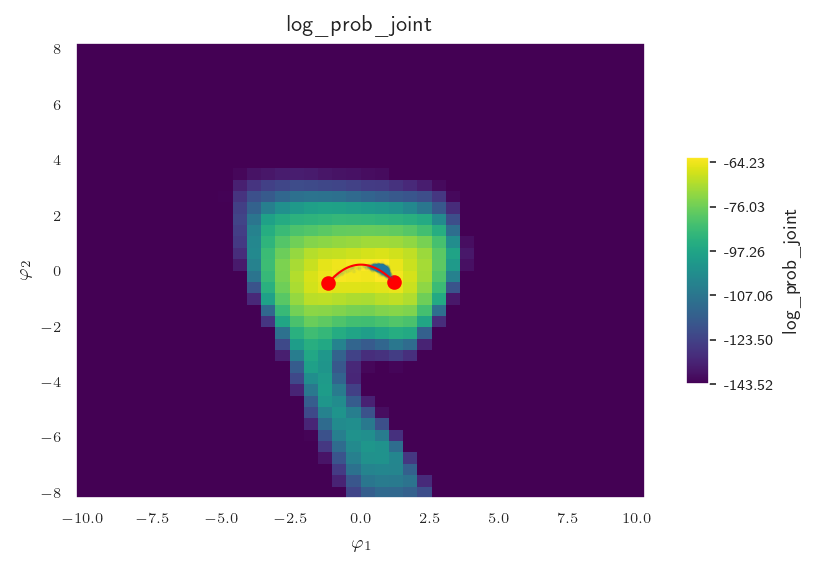

In [15]:
az_post_hmc, mcmc, pyro_model = run_hmc_on_subspace_no_struct(num_chains=10, 
                                                  num_warmup=200, 
                                                  num_samples=200, 
                                                  prior_scale=1.,
                                                  exp_col=exp_col,
                                                  curve_model=best_curve_model,
                                                  curve_wandb_id=wandb_curve_exp_id)

In [16]:
az.summary(az_post_hmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.152,0.006,0.141,0.163,0.000,0.000,1322.0,1230.0,1.01
varphi[0],0.703,0.255,0.396,1.047,0.020,0.014,469.0,235.0,1.02
varphi[1],0.066,0.094,-0.128,0.210,0.004,0.003,766.0,733.0,1.01


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'varphi\n0'}>,
        <Axes: title={'center': 'varphi\n0'}>],
       [<Axes: title={'center': 'varphi\n1'}>,
        <Axes: title={'center': 'varphi\n1'}>]], dtype=object)

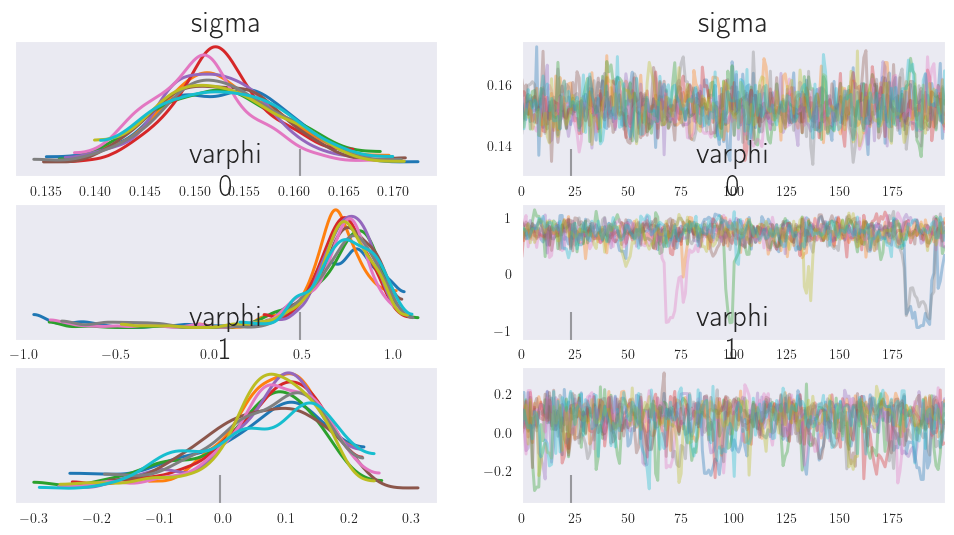

In [17]:
az.plot_trace(az_post_hmc, compact=False)

Yacht
- Mir -1.3 (-0.98 mit dim = 10)
- MCMC s.c. 1.29 +- 0.56
- MCMC theirs 1.9 +- 0.16
- DE -1.14 +-0.14
- LA -5.6 +-1.51


In [18]:
u_test, y_test = exp_col.test_dataloader.dataset[:]
lppd_test = log_pointwise_predictive_likelihood(pyro_model, mcmc.get_samples(), u=u_test, y=y_test.squeeze())
lppd_test2 = (torch.logsumexp(lppd_test, dim=0) - np.log(lppd_test.shape[0])).sum()
lppd_test2 / len(y_test)

tensor(0.5892, device='cuda:0', grad_fn=<DivBackward0>)

In [14]:
prob = torch.exp(lppd_test)
torch.log(prob.mean(0)).mean()

tensor(-1.3886, device='cuda:0', grad_fn=<MeanBackward0>)

In [15]:
az.summary(az_post_hmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
varphi[0],0.467,0.959,-0.567,1.906,0.292,0.212,17.0,189.0,1.67
varphi[1],0.151,1.712,-2.123,1.950,0.526,0.383,17.0,258.0,1.67


array([[<Axes: >, None],
       [<Axes: xlabel='varphi\n0', ylabel='varphi\n1'>, <Axes: >]],
      dtype=object)

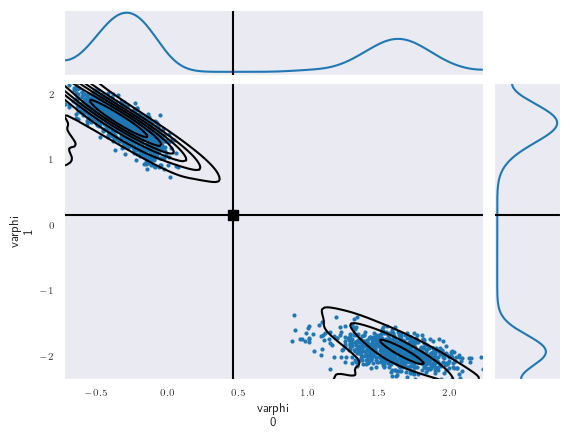

In [16]:
az.plot_pair(az_post_hmc,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="mean",)

array([[<Axes: title={'center': 'varphi\n0'}>,
        <Axes: title={'center': 'varphi\n0'}>],
       [<Axes: title={'center': 'varphi\n1'}>,
        <Axes: title={'center': 'varphi\n1'}>]], dtype=object)

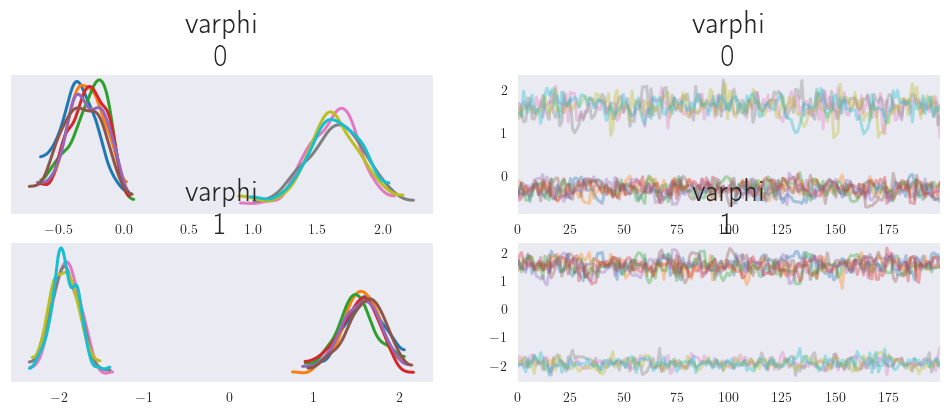

In [17]:
az.plot_trace(az_post_hmc, compact=False)

In [18]:
mu = data_train.params['mean'][-1]
var = data_train.params['var'][-1]

In [36]:
getModel(RegNet, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(
        device=device).dnn

RegNet


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(


Sequential(
  (0): Linear(in_features=6, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
from src.pyro_models import pyroSubspaceUCI_Zt
import json
from pyro import poutine

In [19]:
with open('mu_sigma.json', 'r') as f:
    mu_Simga = json.load(f)
mu = mu_Simga['yacht']['mean_y'][0]
sigma = np.sqrt(mu_Simga['yacht']['var_y']).item()
print(f"mu: {mu}, sigma:{sigma}")
u_test, y_test = exp_col.test_dataloader.dataset[:]
y_test_scale = y_test*sigma + mu

num_samples = list(mcmc.get_samples().values())[0].shape[0]
log_probs = []
samples = [
    {k: v[i] for k, v in mcmc.get_samples().items()} for i in range(num_samples)
]
pyro_model_z = pyroSubspaceUCI_Zt(mean=pyro_model.mean,
                                    cov_factor=pyro_model.cov,
                                    sequential_dnn=getModel(RegNet, **exp_col.base_net_kwargs, **exp_col.net_kwargs).to(device=device).dnn,
                                    z_mean=mu,
                                    z_scale=sigma)

for i in range(num_samples):
    trace = poutine.trace(poutine.condition(pyro_model_z, samples[i])).get_trace(u=u_test, y=y_test_scale.squeeze())
    trace.compute_log_prob()
    log_probs.append(trace.nodes['obs']["log_prob"])
ll_test_unscale = torch.stack(log_probs)
lppd_test_unscale = (torch.logsumexp(ll_test_unscale, dim=0) - np.log(ll_test_unscale.shape[0])).sum()
lppd_test_unscale / len(y_test)

mu: 10.41170731707317, sigma:15.0511150064946
RegNet


tensor(-4.1043, device='cuda:0', grad_fn=<DivBackward0>)

In [24]:
torch.randint(0,1000,(1,)).item()

794

In [26]:
DatasetFactory()

1

In [ ]:
# check scale unscale
import torch
xx = torch.randn(10000000)*11 +3.3
mu = 3.
std = 2.

z_xx = (xx - mu)/std

print(z_xx.mean(), z_xx.std())

mu_x = z_xx.mean()*std + mu
print("mu_x", mu_x)

std_x = torch.sqrt(z_xx.var() * std**2)
print("std_x", std_x)

tensor(0.1477) tensor(5.5003)
mu_x tensor(3.2953)
std_x tensor(11.0006)
